In [41]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from scipy.stats import beta
from enum import IntEnum
import math
import random
import os

# Helper Functions

In [42]:
def distance_multidimensional(point1, point2) -> float:
    sqSum = 0.0
    for i in range(len(point1)):
        print(sqSum)
        sqSum += (point1[i] - point2[i]) ** 2
    return math.sqrt(sqSum)

# Set Up

In [43]:
datafilename: str = 'StoneFlakes.dat' 

- Storing filename with all the data.

In [44]:
num_samples = 79 
num_features = 8

* Reading data from file

In [45]:
try:
    with open( datafilename ) as infile:
        indata = csv.reader( infile )
        data = np.empty(( num_samples, num_features ))
        i = 0
        for j, d in enumerate( indata ):
            if j==0: continue       # Avoid the first line of the file because it has
            ok = True               # column identifiers in it.
            # Delete the ID string of every line
            save=""
            for k in d[0]:
                try:
                    save=save+str(int(k))
                except Exception as e:
                    if k=='.':
                        save=save+'.'
                    if k=='?':
                        save=save+'?'
            d[0]=save
            # d[0] = 0
            for k in range(1,num_features):     # If a feature has a missing value
                if '?' in d[k]:                 # we don't use that record.
                    ok = False
            if ( ok ):
                data[i] = np.asarray( d[:], dtype=np.float64 )
                i = i + 1
except IOError as iox:
    print('there was an I/O error trying to open the data file: ' + str( iox ))
    sys.exit()
except Exception as x:
    print('there was an error: ' + str( x ))
    sys.exit()

* Checking data by printing number of samples

In [46]:
num_samples: int = i
print("\n Number of samples:", num_samples)


 Number of samples: 73


In [47]:
data = data[:i]
print(data)

[[  1.23  27.     3.59 122.     0.    40.    40.    30.  ]
 [  1.24  26.5    2.9  121.    16.    20.7   29.7   72.  ]
 [ 11.07  29.1    3.1  114.    44.     2.6   26.3   68.  ]
 [ 21.08  43.7    2.4  105.    32.6    5.8   10.7   42.  ]
 [  1.39  29.5    2.78 126.    14.     0.    50.    78.  ]
 [  1.31  26.3    2.1  119.    15.7   15.7   30.4   72.  ]
 [  1.27  27.6    3.5  116.    16.8   23.    35.2   69.  ]
 [  1.11  32.6    2.9  113.    15.8   15.8   15.    57.  ]
 [  1.32  29.5    2.57 121.    22.     2.    18.    63.  ]
 [  1.16  33.4    2.3  131.     7.5   14.9    6.    60.  ]
 [  1.23  27.6    2.83 121.    27.9    6.7   31.7   67.  ]
 [ 11.24  25.5    3.6  113.     5.3   21.1   60.    86.  ]
 [ 21.2   27.7    3.4  108.    37.4    9.9   39.9   71.  ]
 [  1.33  29.4    2.3  120.    13.5    6.9   38.3   72.  ]
 [  1.11  35.1    3.51 123.    67.2    2.5    5.9   46.  ]
 [101.14  29.9    2.9  116.     5.3   55.3   63.2   84.  ]
 [111.16  27.9    3.   116.     3.5   23.7   64.8   85. 

# Learning (K-Means)

**Question 6**

**Attributes:**
* LBI: Length-breadth index of the striking platform 
* RTI: Relative-thickness index of the striking platform 
* WDI: Width-depth index of the striking platform 
* FLA: Flaking angle (the angle between the striking platform and the splitting surface) 
* PSF: platform primery (yes/no, relative frequency) 
* FSF: Platform facetted (yes/no, relative frequency) 
* ZDF1: Dorsal surface totally worked (yes/no, relative frequency) 
* PROZD: Proportion of worked dorsal surface (continuous)

In [48]:
class StoneFeatures(IntEnum):
    lbi      = 0  # Length-breadth index of the striking platform 
    rti      = 1  # Relative-thickness index of the striking platform
    wdi      = 2  # Width-depth index of the striking platform
    fla      = 3  # Flaking angle (between striking platform and splitting surface)
    psf      = 4  # Platform primery (yes/no, relative frequency)
    fsf      = 5  # Platform facetted (yes/no, relative frequency)
    zdf1     = 6  # Dorsal surface totally worked (yes/no, relative frequency)
    prozd    = 7  # Proportion of worked dorsal surface (continuous)

Storing:
* Number of samples
* Number of features

In [49]:
minClusterNum: int = 2
maxClusterNum: int = 6

# A loop for each number of clusters

error: float = 0.01   # convergence is no cluster center moving more than this


2 clusters:

Initial clusters:
[[88, 41, 1, 128, 63, 16, 73, 54], [5, 16, 2, 108, 61, 16, 66, 33]]


0.0
7529.032899999999
7725.032899999999
7731.740999999999
7767.740999999999
11736.740999999998
12312.740999999998
13401.740999999998
0.0
14.2129
135.2129
137.74099999999999
333.741
4054.741
4630.741
5306.741
0.0
7527.297600000001
7737.547600000001
7741.1576000000005
7790.1576000000005
9999.1576
10021.2476
11896.1376
0.0
14.137599999999999
124.38759999999999
125.1976
294.19759999999997
2319.1976
2341.2876
3658.9776
0.0
5918.224900000001
6059.834900000001
6064.244900000001
6260.244900000001
6621.244900000001
6800.804900000001
8981.694900000002
0.0
36.8449
208.45490000000004
209.66490000000005
245.66490000000005
534.6649
714.2248999999999
2290.3149000000003
0.0
4478.2864
4485.5764
4487.5364
5016.5364
5940.6964
6044.7364
9926.026399999999
0.0
258.56639999999993
1025.8564000000001
1026.0164000000002
1035.0164000000002
1841.5764000000001
1945.6164
5003.7064
0.0
7501.2921
7633.5421
7636.71049

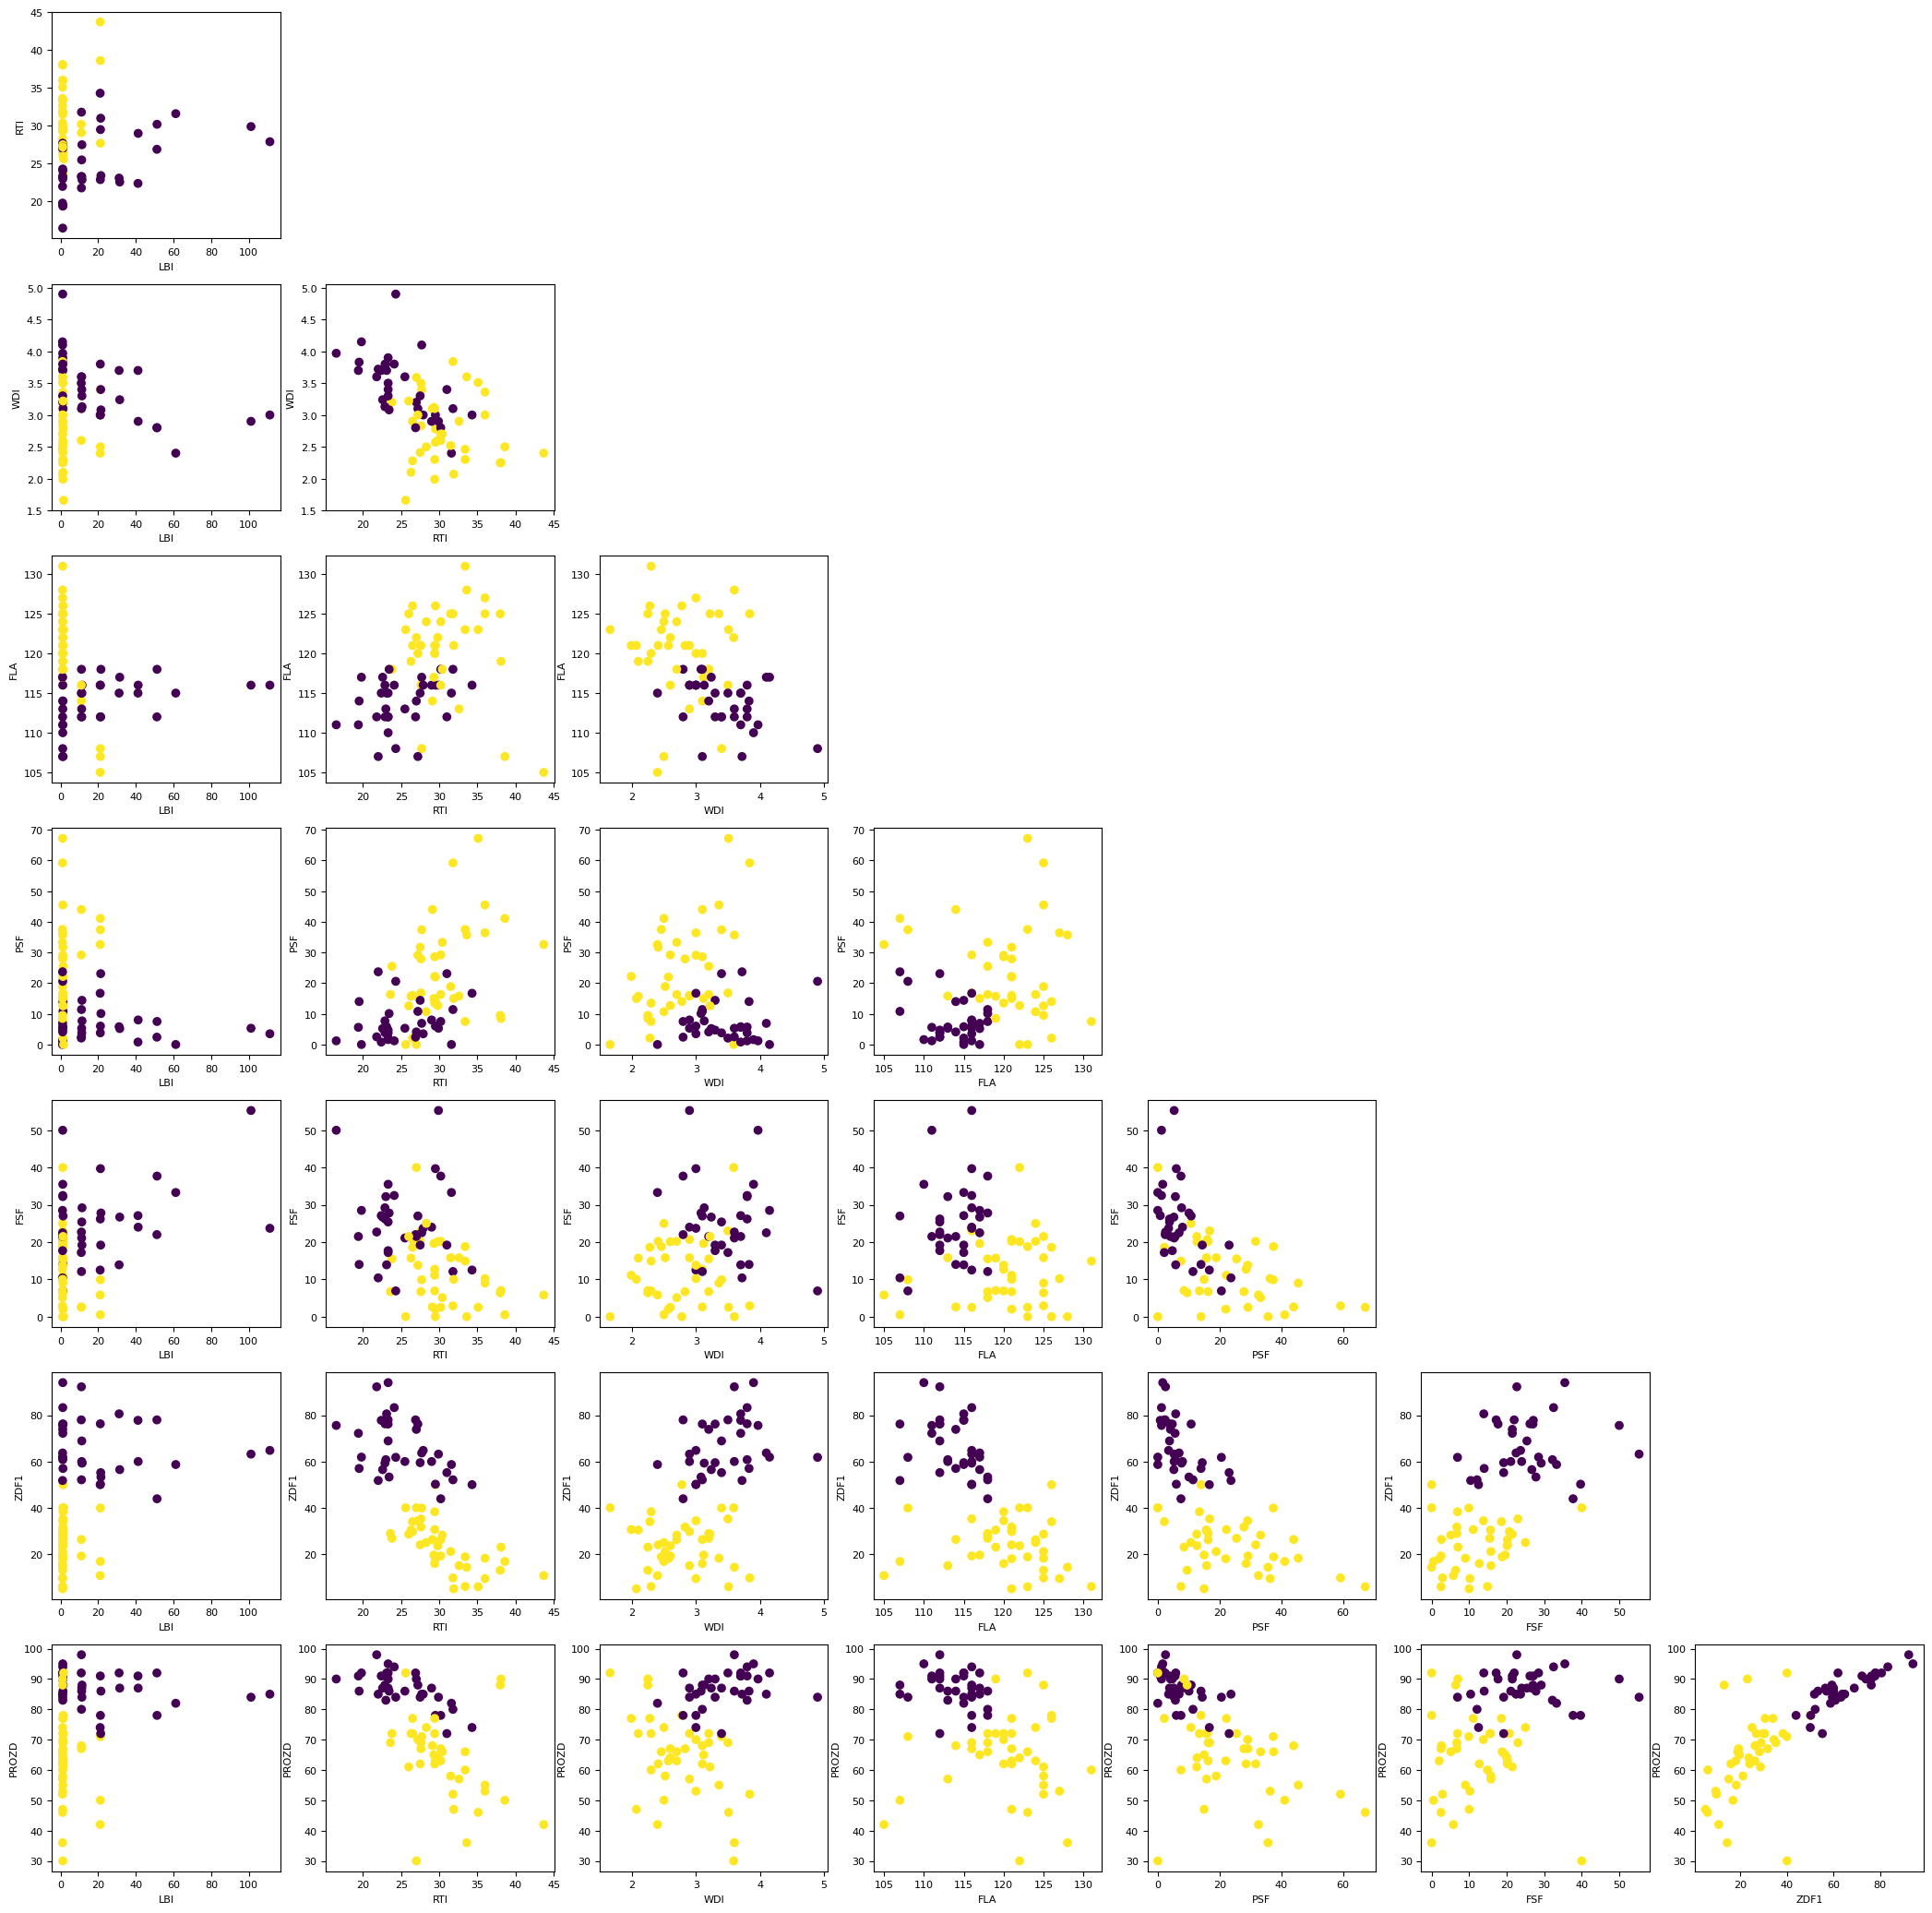


3 clusters:

Initial clusters:
[[92, 19, 2, 112, 48, 46, 52, 52], [10, 41, 2, 126, 18, 25, 55, 79], [110, 17, 1, 118, 44, 35, 69, 45]]


0.0
8239.1929
8303.1929
8305.721
8405.721
10709.721
10745.721
10889.721
0.0
76.9129
272.9129
275.441
291.441
615.441
840.441
1065.441
0.0
11830.9129
11930.9129
11937.621
11953.621
13889.621
13914.621
14755.621
0.0
8237.377600000002
8293.627600000002
8294.437600000001
8375.437600000001
9399.437600000001
10039.527600000001
10536.817600000002
0.0
76.7376
286.9876
287.7976
312.7976
316.7976
335.2876
975.3776
0.0
11828.7376
11918.9876
11922.597600000001
11931.597600000001
12715.597600000001
12920.0876
14464.5776
0.0
6549.664900000001
6651.674900000001
6652.884900000001
6656.884900000001
6672.884900000001
8556.4449
9216.9349
0.0
1.1449000000000007
142.75489999999996
143.96489999999997
287.96489999999994
963.9649
1465.7249
2289.4148999999998
0.0
9787.144900000001
9933.554900000001
9937.9649
9953.9649
9953.9649
11003.724900000001
12827.014900000002
0.0
5029.

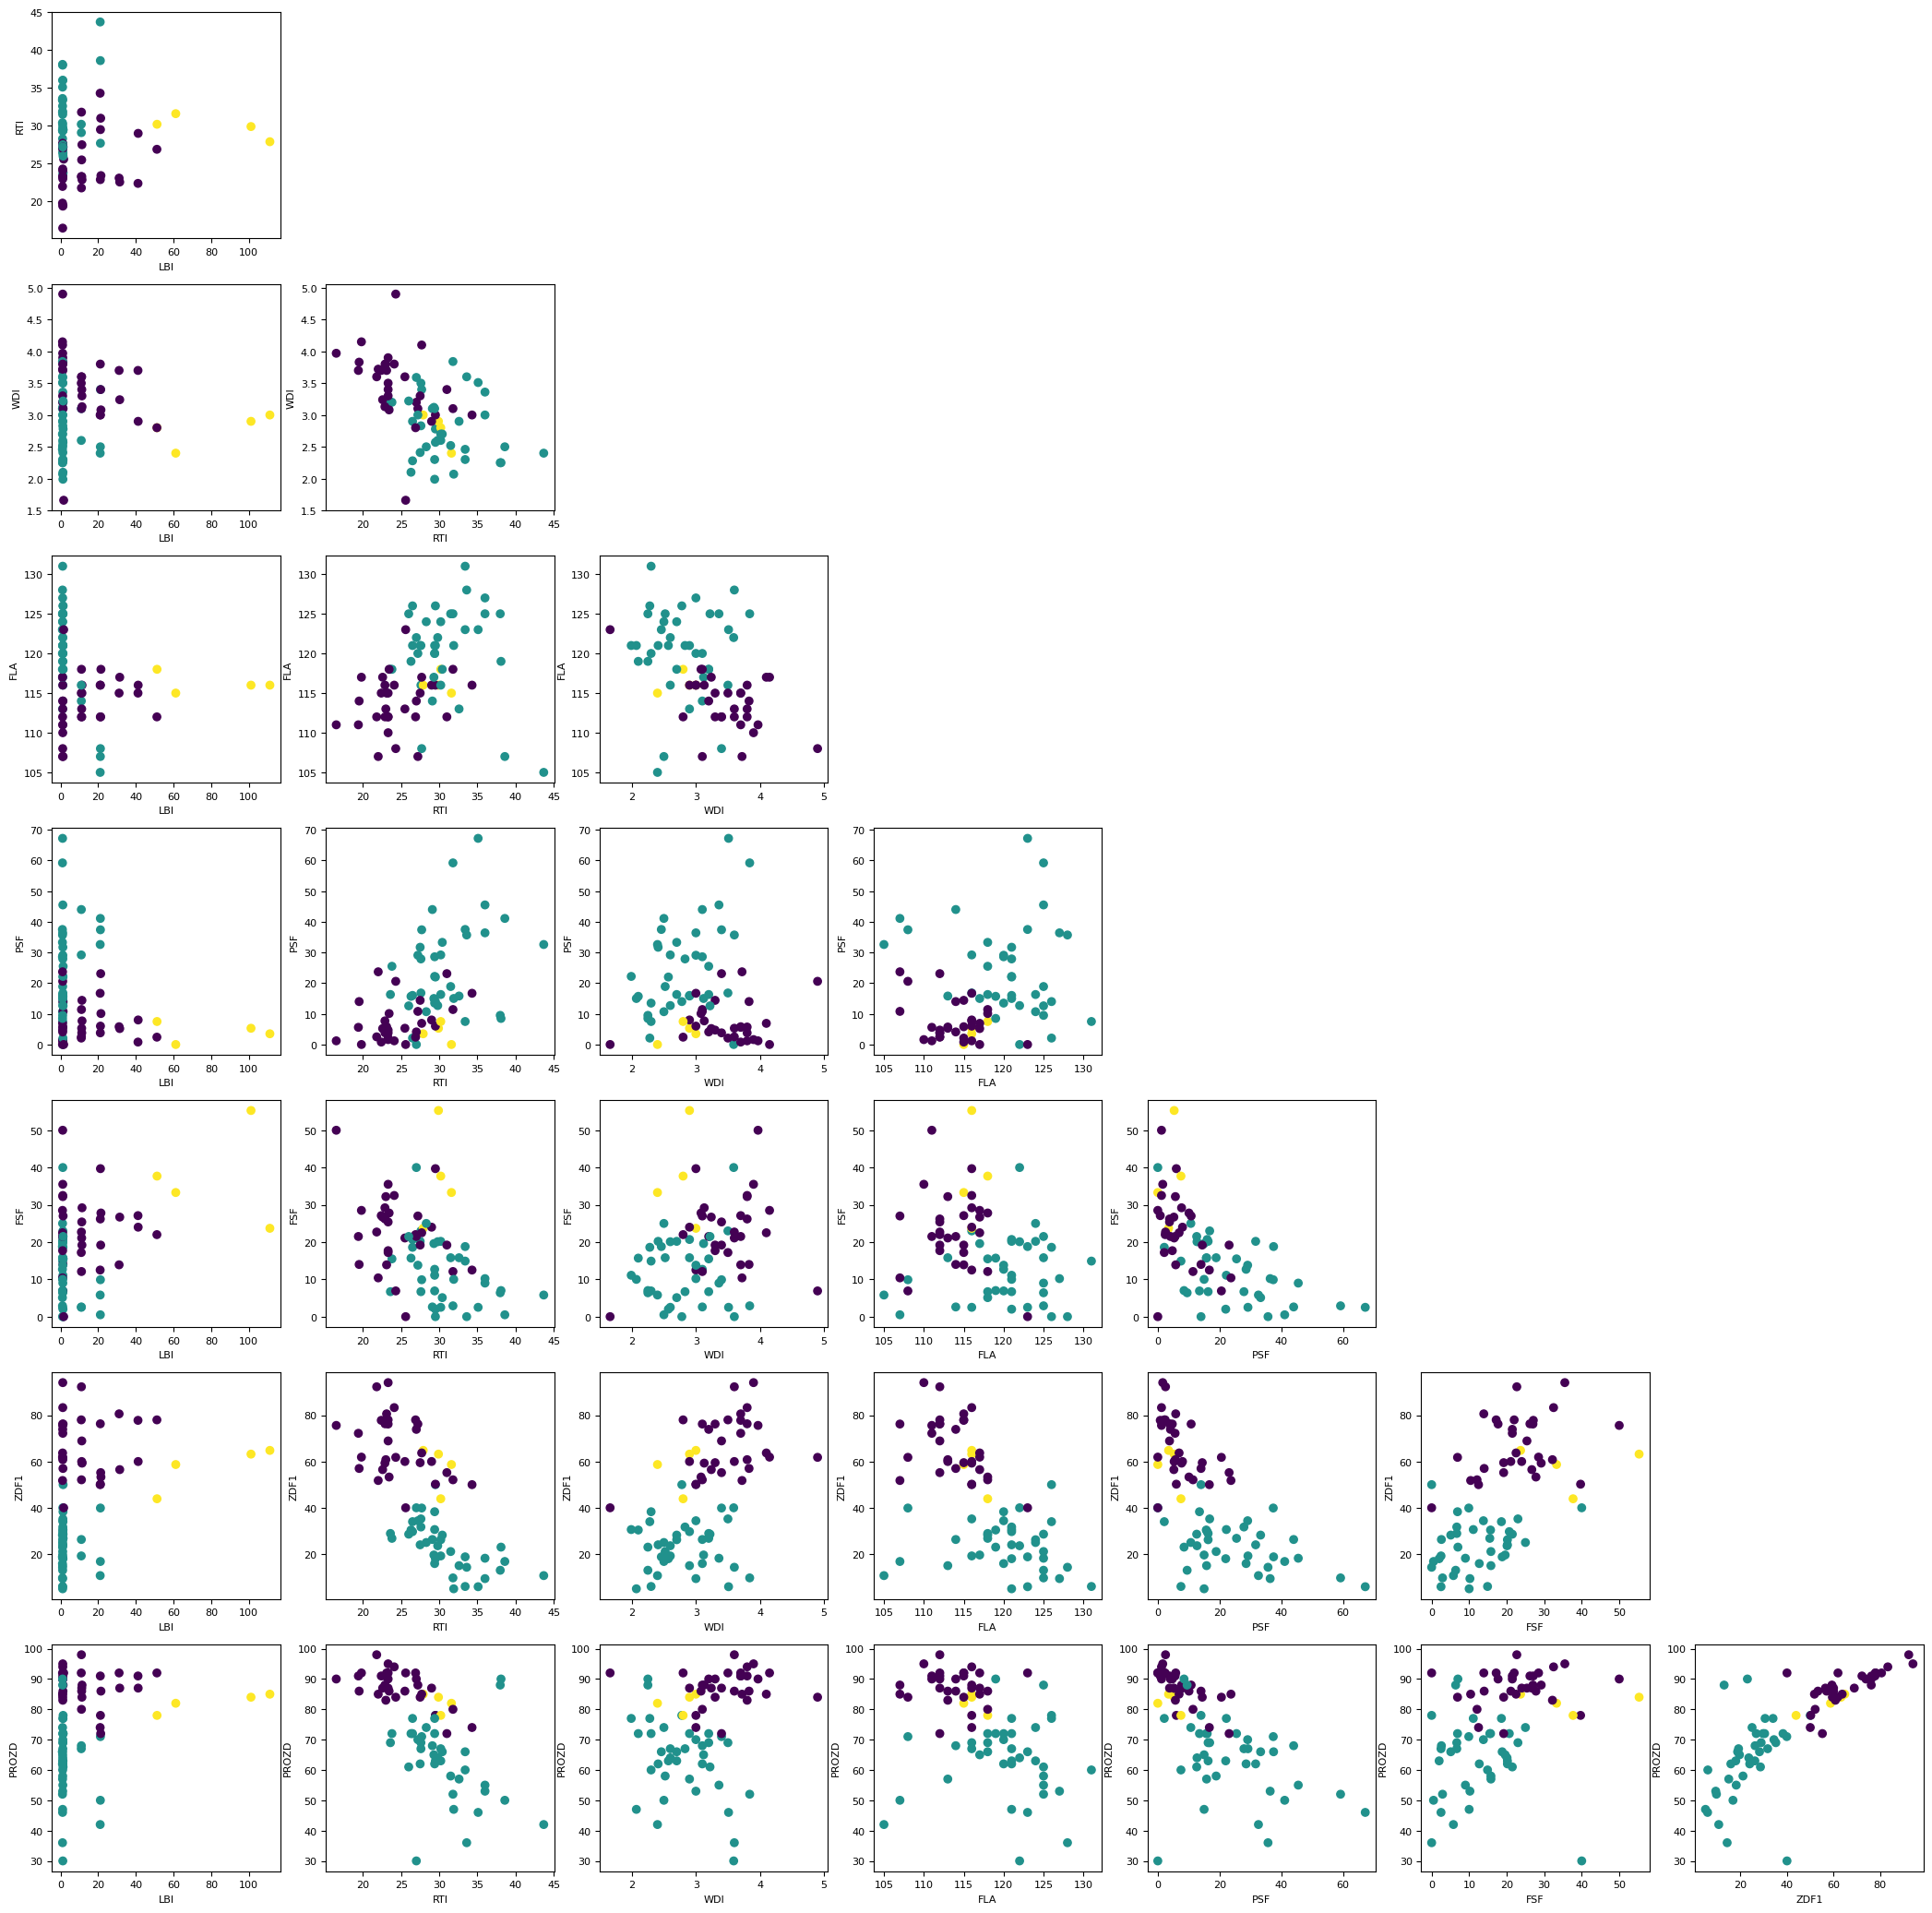


4 clusters:

Initial clusters:
[[13, 26, 2, 113, 2, 42, 16, 68], [88, 32, 1, 112, 41, 2, 45, 66], [3, 33, 1, 124, 44, 15, 58, 72], [43, 20, 1, 114, 5, 52, 60, 34]]


0.0
138.53289999999998
139.53289999999998
142.06099999999998
223.06099999999998
227.06099999999998
231.06099999999998
807.0609999999999
0.0
7529.032899999999
7554.032899999999
7560.740999999999
7660.740999999999
9341.740999999998
10785.740999999998
10810.740999999998
0.0
3.1329000000000002
39.1329
45.841
49.841
1985.841
2610.841
2934.841
0.0
1744.7329000000002
1793.7329000000002
1800.4410000000003
1864.4410000000003
1889.4410000000003
2033.4410000000003
2433.4410000000003
0.0
138.2976
138.5476
139.3576
203.3576
399.3576
853.0476000000001
1040.7376000000002
0.0
7527.297600000001
7557.547600000001
7561.1576000000005
7642.1576000000005
8267.1576
8616.847600000001
8850.937600000001
0.0
3.0976
45.3476
48.9576
57.9576
841.9576
874.4476
1675.3375999999998
0.0
1743.8975999999998
1786.1475999999998
1789.7575999999997
1838.75759999

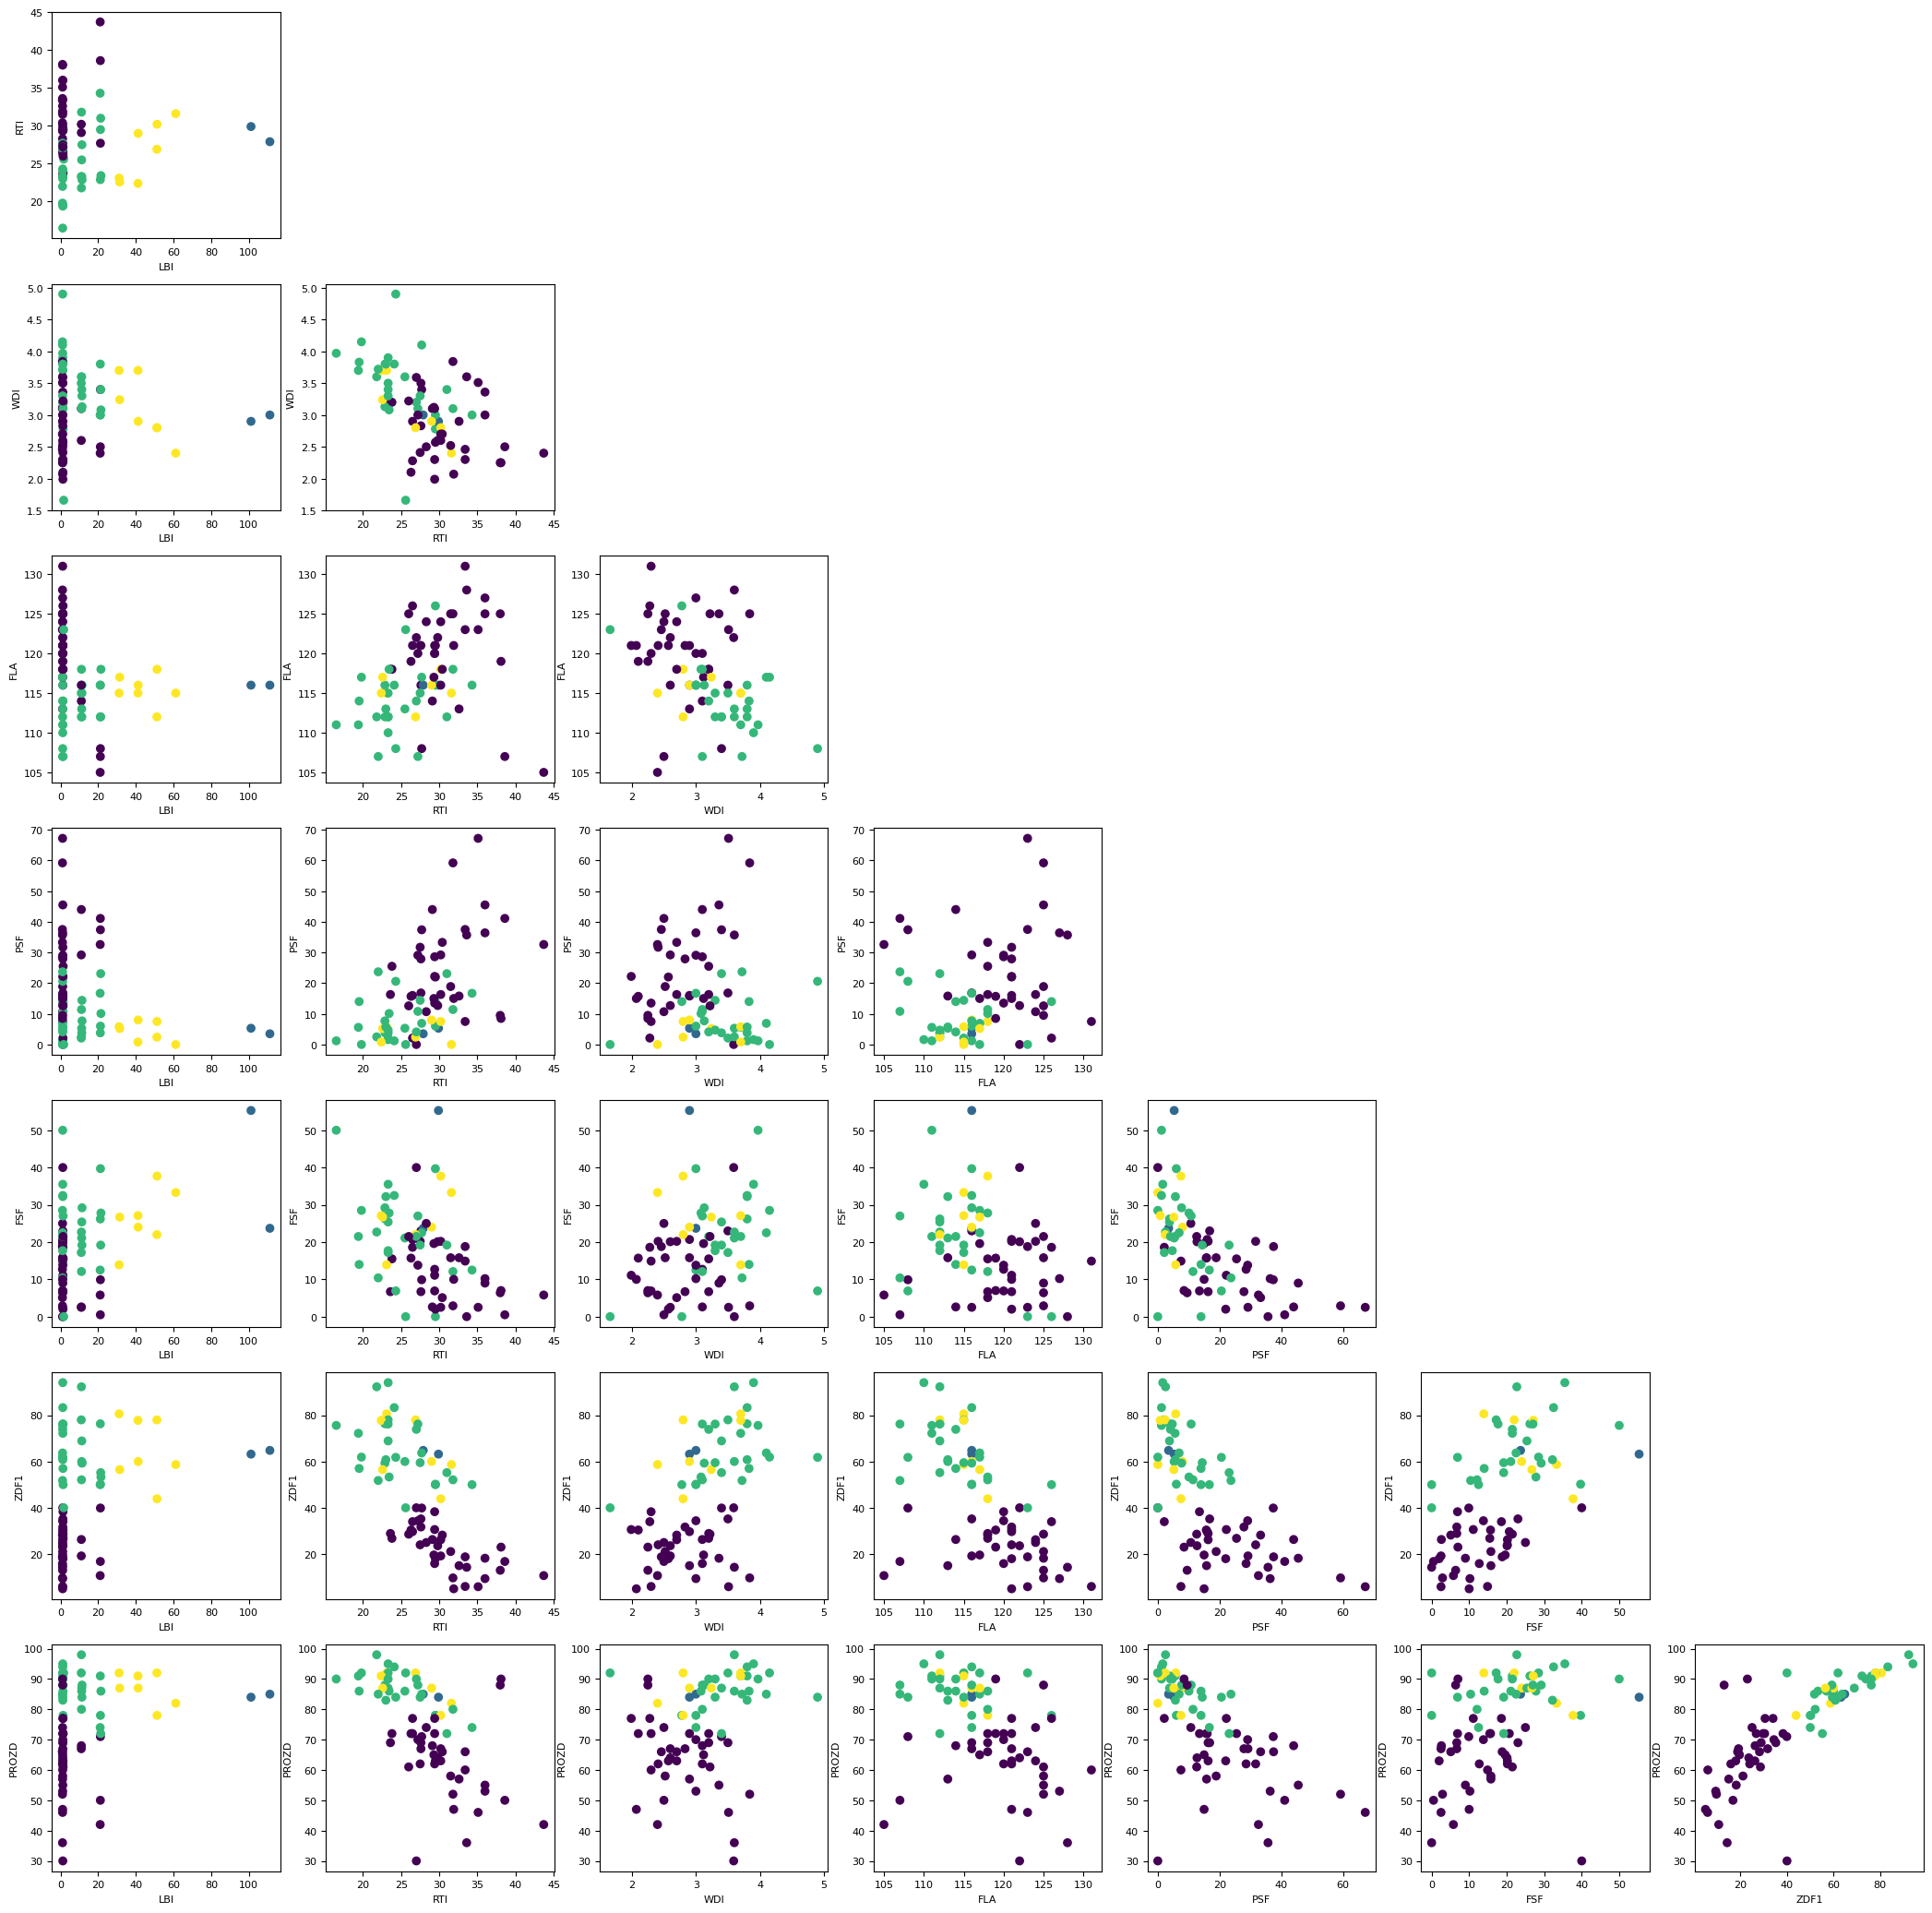


5 clusters:

Initial clusters:
[[32, 39, 4, 111, 6, 7, 42, 75], [73, 40, 4, 117, 28, 15, 44, 37], [87, 32, 1, 126, 52, 36, 82, 67], [33, 28, 2, 125, 39, 7, 38, 76], [84, 23, 1, 121, 1, 40, 72, 89]]


0.0
946.7928999999999
1090.7929
1090.961
1211.961
1247.961
2336.9610000000002
2340.9610000000002
0.0
5150.9329
5319.9329
5320.101
5345.101
6129.101
6754.101
6770.101
0.0
7356.492899999999
7381.492899999999
7388.200999999999
7404.200999999999
10108.201
10124.201
11888.201
0.0
1009.3329
1010.3329
1012.861
1021.861
2542.861
3631.861
3635.861
0.0
6850.872899999999
6866.872899999999
6873.580999999999
6874.580999999999
6875.580999999999
6875.580999999999
7899.580999999999
0.0
946.1776000000001
1102.4276
1103.6376
1203.6376
1303.6376
1491.3276
1642.6176
0.0
5149.497600000001
5331.747600000001
5332.957600000001
5348.957600000001
5492.957600000001
5525.4476
5729.9376
0.0
7354.777600000001
7385.027600000001
7388.637600000001
7413.637600000001
8709.637600000002
8943.727600000002
11679.017600000001
0

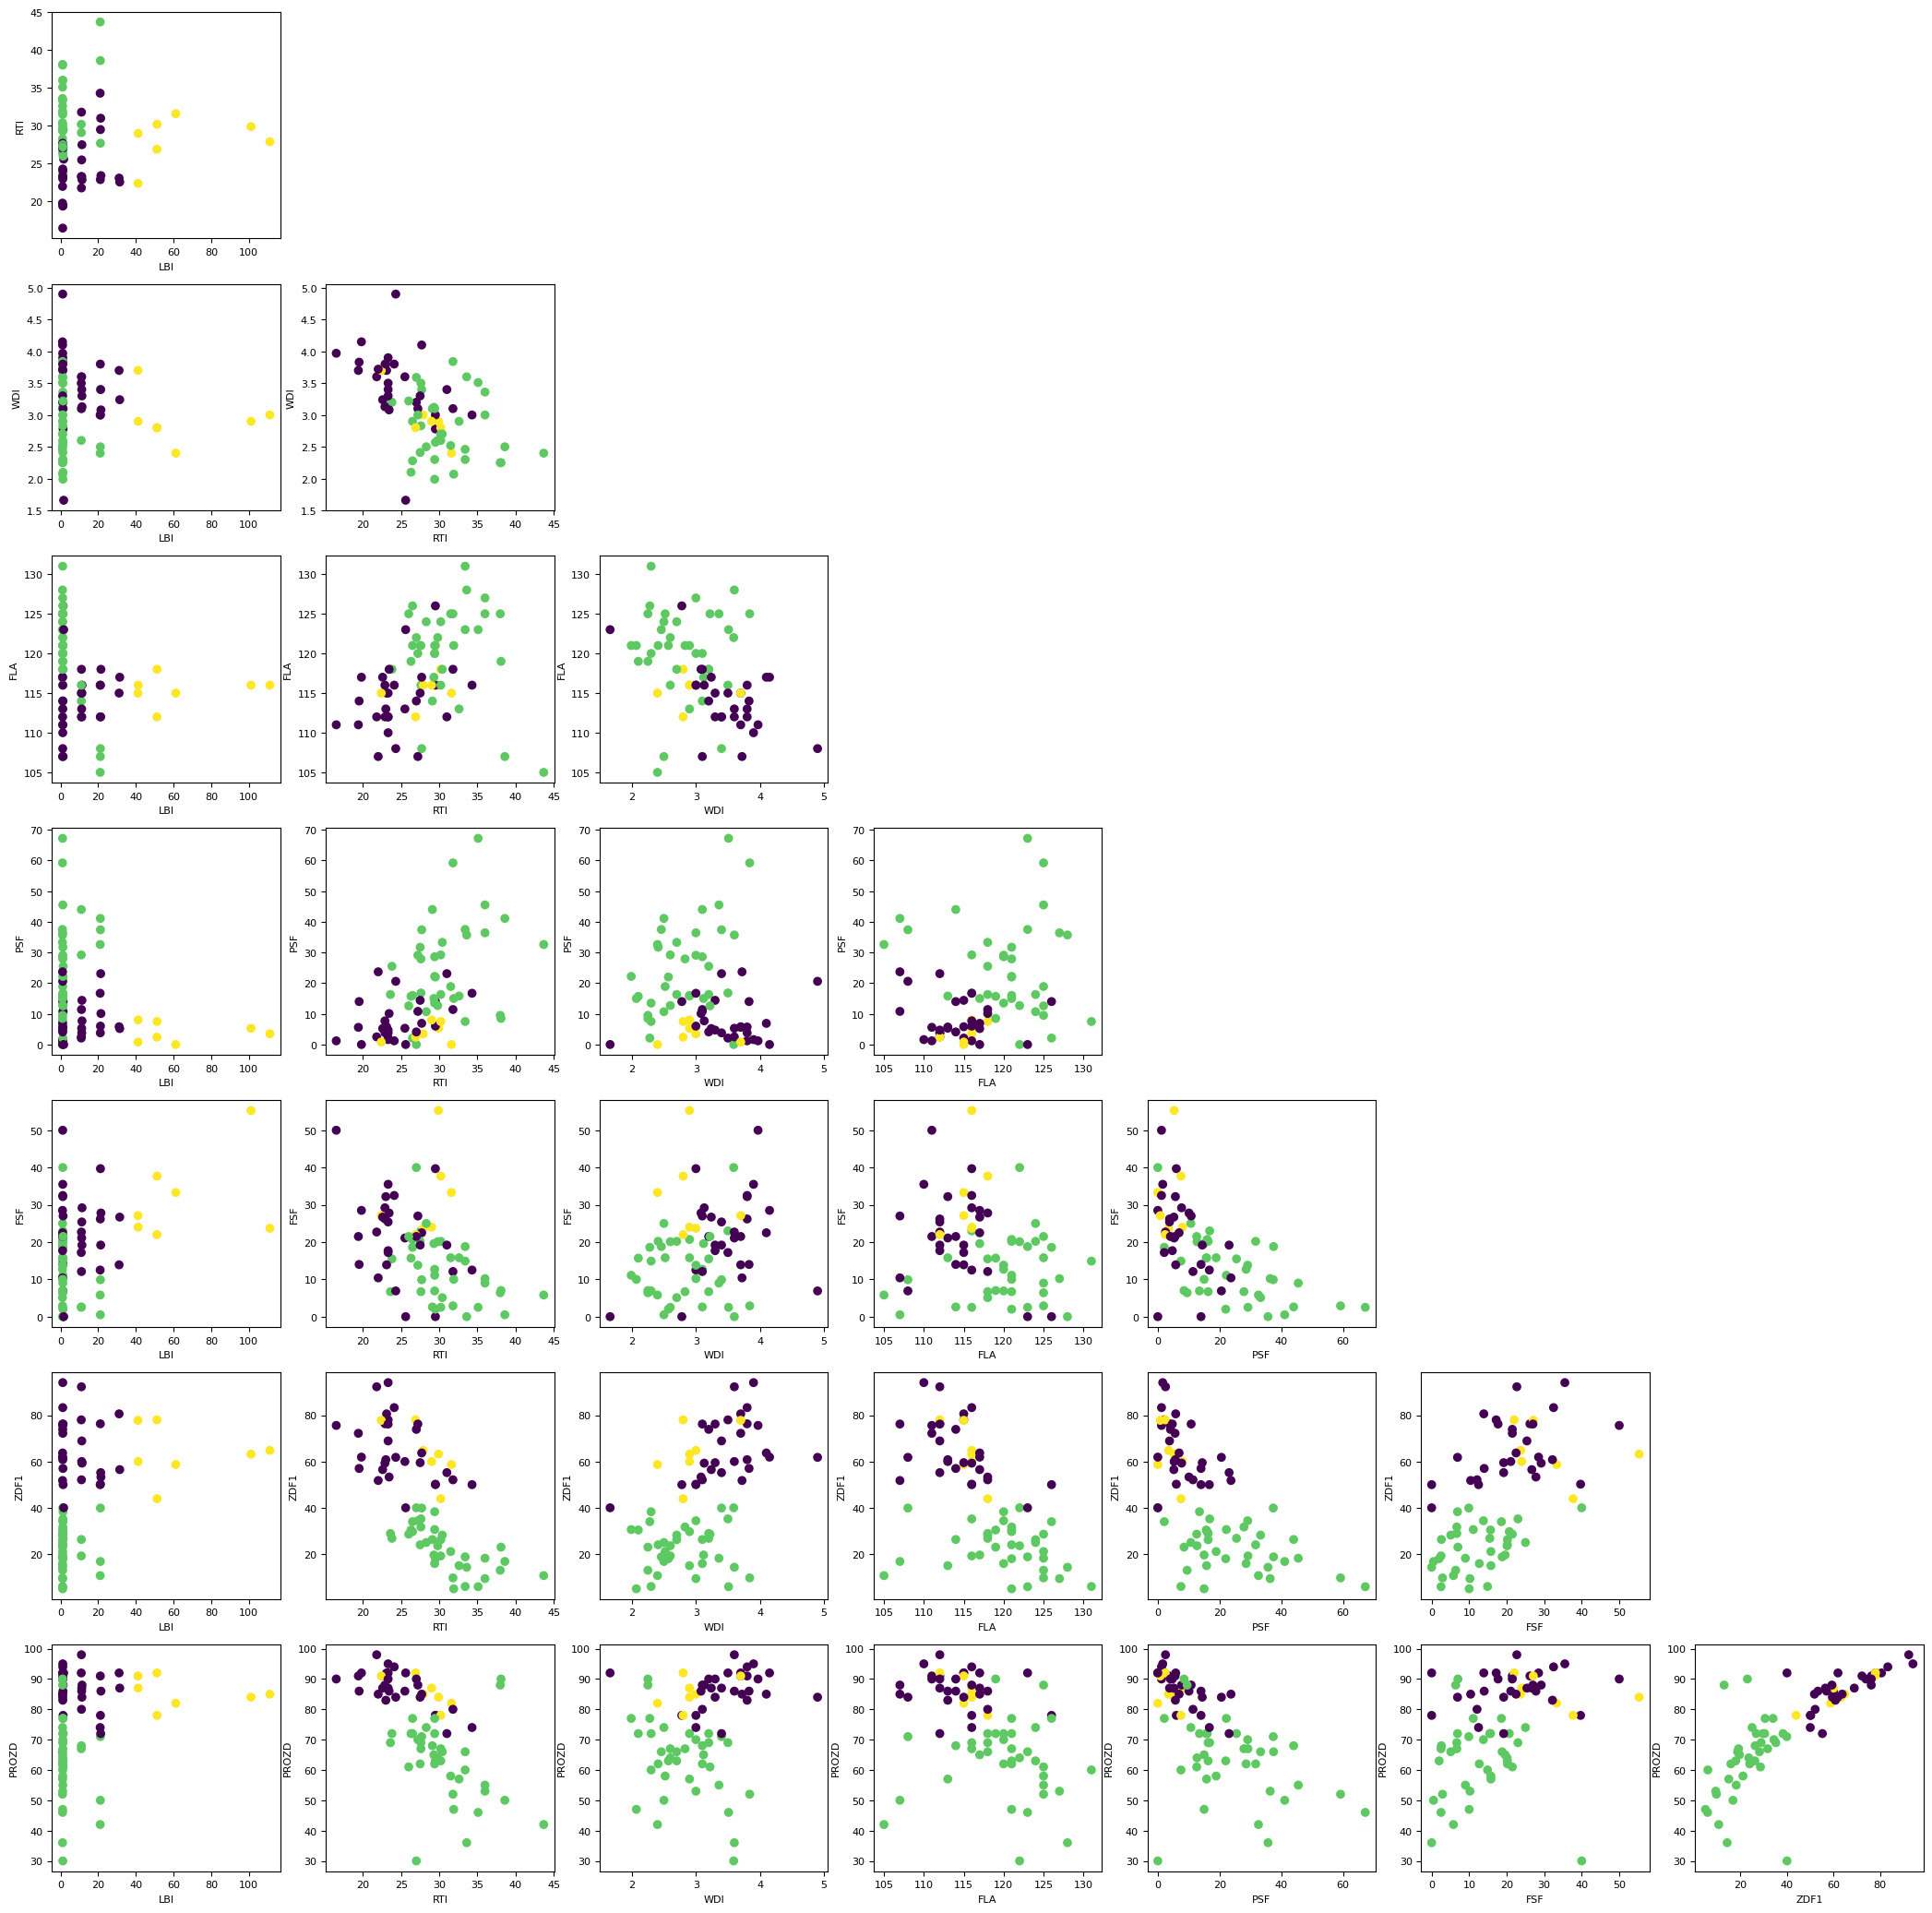


6 clusters:

Initial clusters:
[[86, 22, 3, 123, 40, 43, 49, 33], [25, 38, 2, 123, 53, 25, 66, 94], [12, 35, 3, 113, 56, 36, 56, 57], [26, 29, 2, 111, 19, 7, 42, 80], [43, 29, 1, 108, 34, 51, 79, 41], [71, 19, 4, 108, 31, 17, 8, 57]]


0.0
7185.952899999999
7210.952899999999
7211.3009999999995
7212.3009999999995
8812.301
8821.301
8902.301
0.0
565.0129
686.0129
688.5409999999999
689.5409999999999
3498.541
3723.541
4399.541
0.0
115.99289999999999
179.9929
180.34099999999998
261.341
3397.341
3413.341
3669.341
0.0
613.5529
617.5529
620.081
741.081
1102.0810000000001
2191.081
2195.081
0.0
1744.7329000000002
1748.7329000000002
1755.4410000000003
1951.4410000000003
3107.4410000000003
3228.4410000000003
4749.441000000001
0.0
4867.8529
4931.8529
4932.021
5128.021
6089.021
6618.021
7642.021
0.0
7184.257600000001
7204.507600000001
7204.517600000001
7208.517600000001
7784.517600000001
8281.807600000002
8654.297600000002
0.0
564.5376000000001
696.7876000000001
697.5976
701.5976
2070.5976
2089.0876

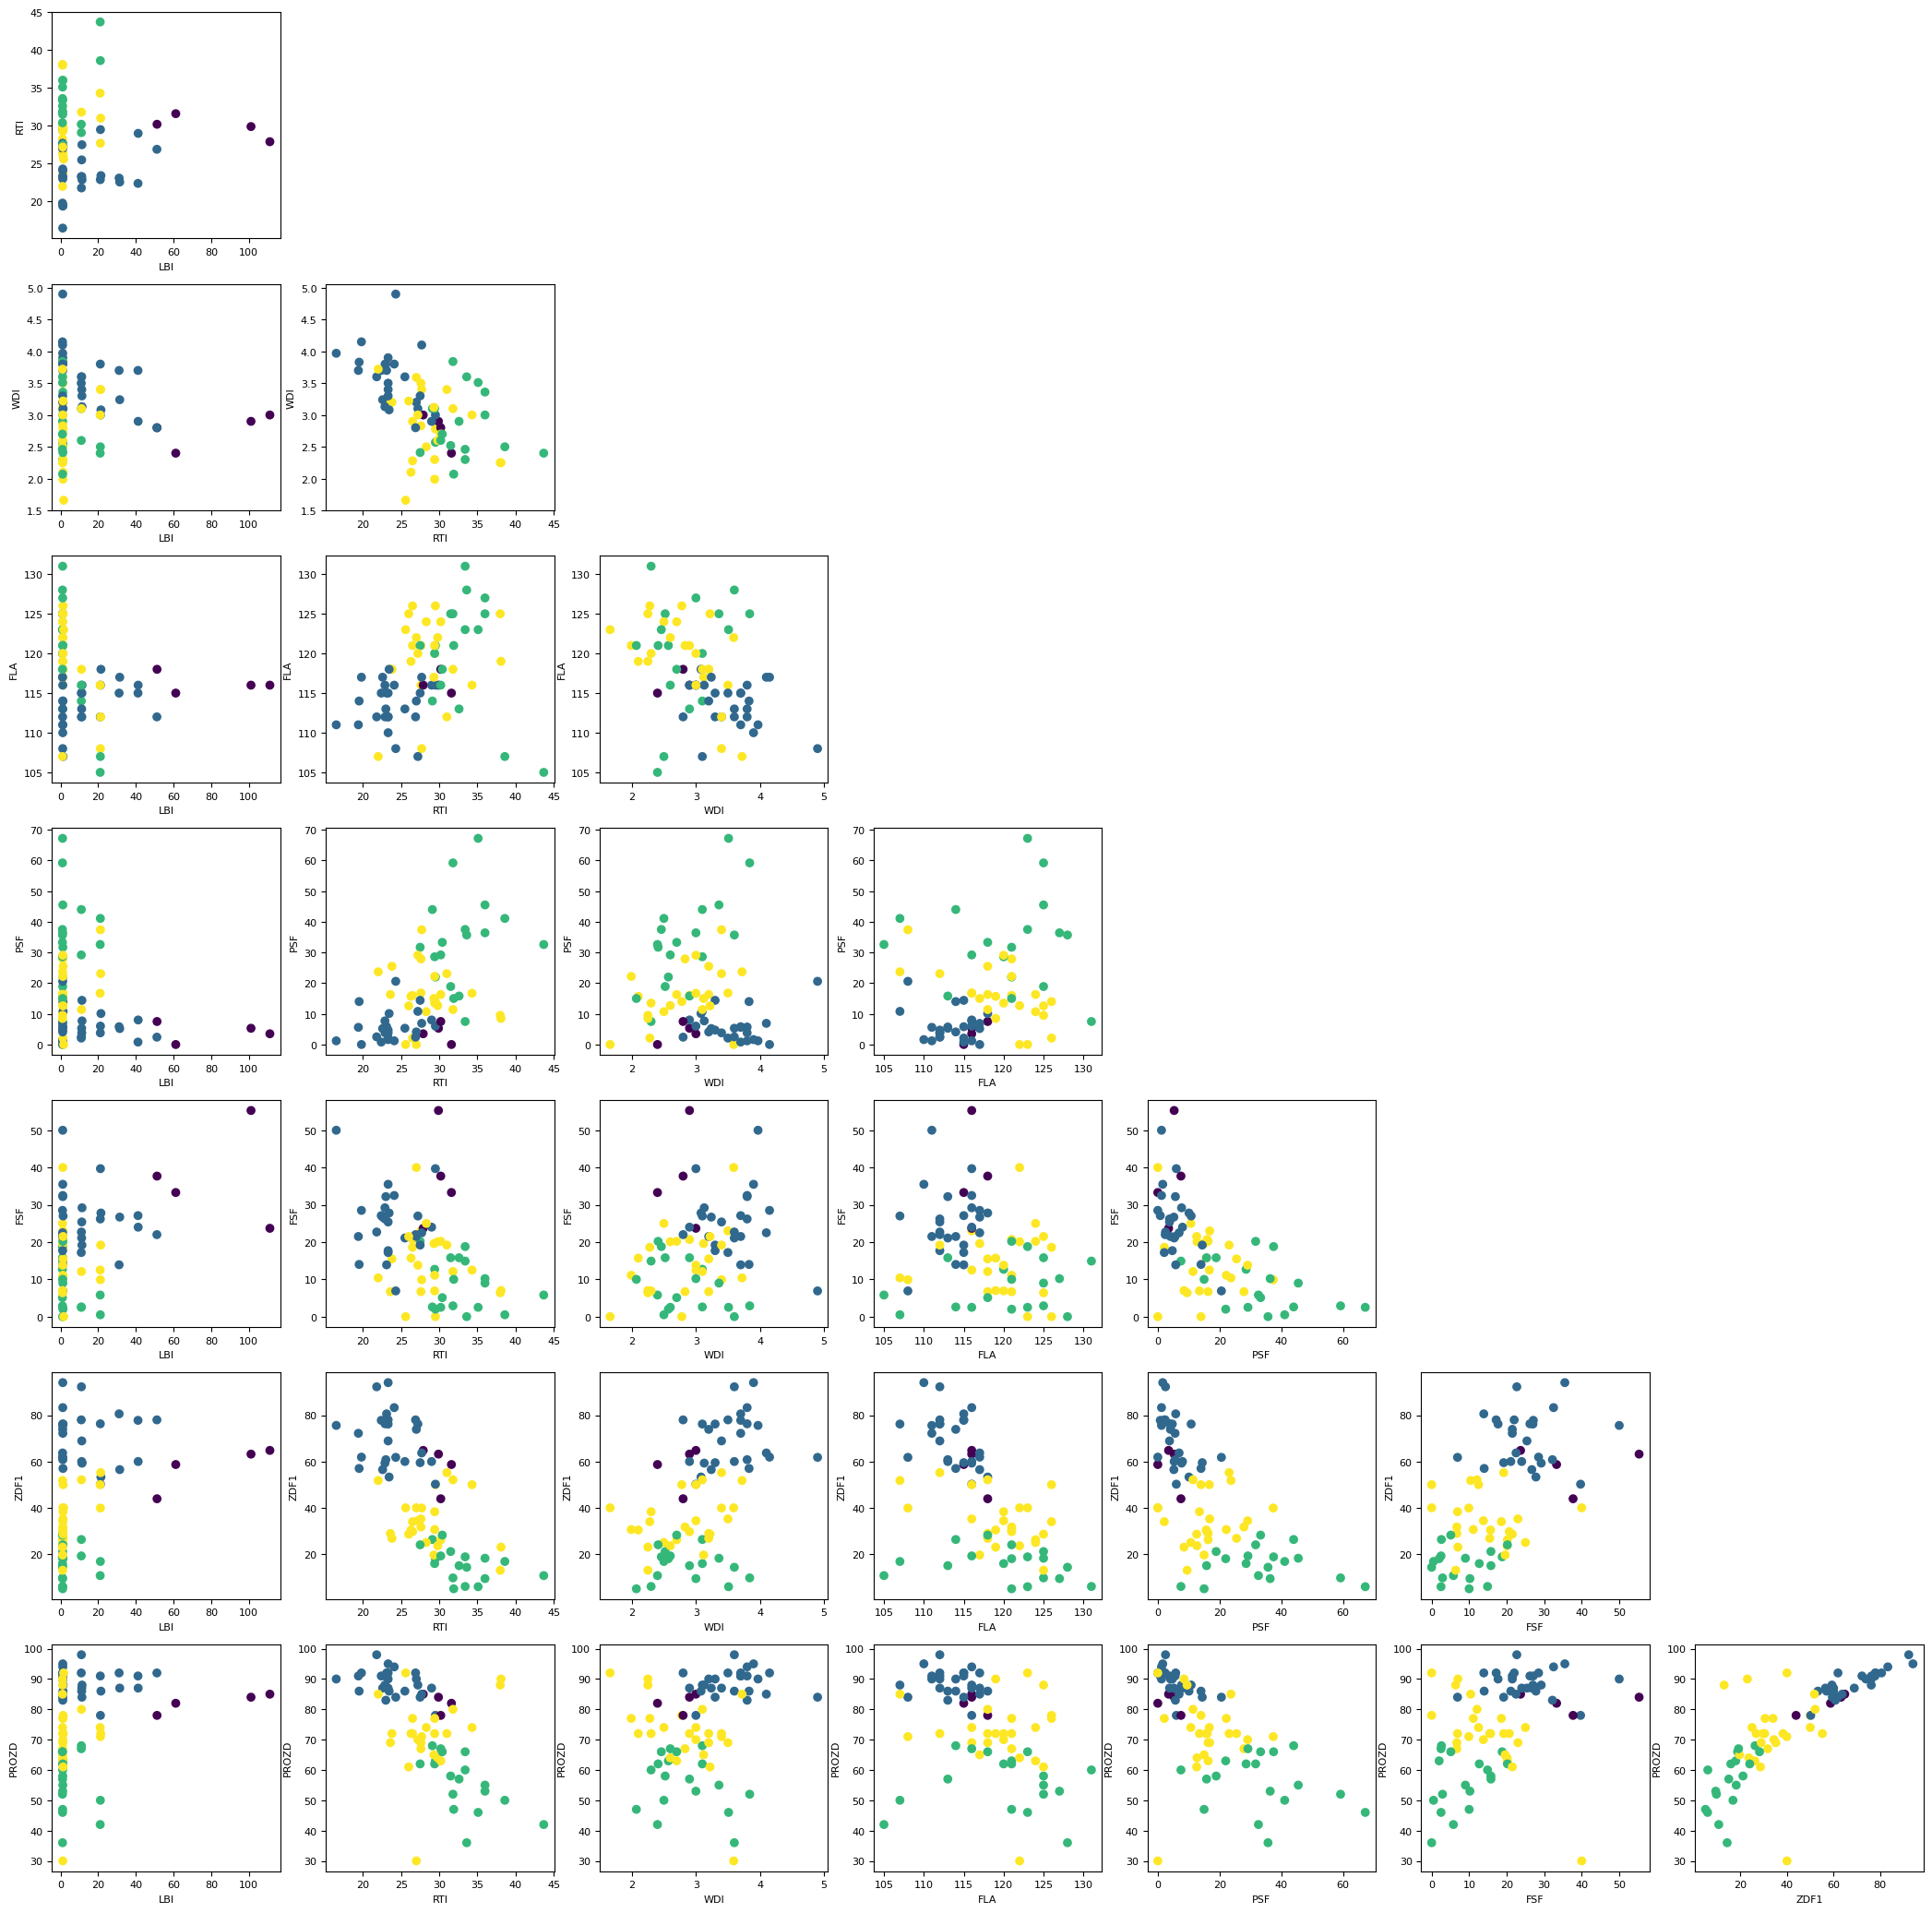

In [50]:
for clusterNum in range (minClusterNum, maxClusterNum+1):

    print("\n"+str(clusterNum)+" clusters:\n")

    #
    # Pick inital cluster centres.
    #
    # Get max and min values of the features we cluster on
    X_min=[]
    X_max=[]
    for i in range(num_features):
        X_min.append(math.floor(data[:,i].min()))
        X_max.append(math.ceil(data[:,i].max()))
        
    # now pick random points in that space.
    clusters = []
    for i in range(clusterNum):
        center=[]
        for j in range(num_features):
            center.append(random.randrange(X_min[j],  X_max[j]))
        clusters.append(center)

    # print initial clsuter centres just in case some of them are duplicates
    print("Initial clusters:")
    print(clusters)
    print("\n")

    #
    # Now run K-means.
    #
    # First build our own version of the data, Xcluster, with an
    # additional element that identifies which cluster the point is
    # in. Initialise that cluster to 0.

    Xcluster = []
    for i in range(len(data)):
        Xcluster.append([data[i], 0])

    stop = 0

    while stop == 0:
        # Assign each point to the cluster with the nearest centre.
        for i in range(len(Xcluster)):
            distances = []
            # For each data point, compute the distance to each cluster center
            for j in range(len(clusters)):
                distances.append(distance_multidimensional(Xcluster[i][0], clusters[j]))

            # Then assign the point to the cluster with the nearest center.
            min_distance=min(distances)
            for j in range(len(clusters)):
                if min_distance == distances[j]:
                    Xcluster[i][1]=j


        # Recompute cluster centres.
        cluster_newCenters=[]
        for i in range(clusterNum):
            cluster_newCenters.append([0]*num_features)
        counts: list[int]=[0]*clusterNum

        # Sum up x and y coordinate values of points in each cluster.
        for i in range(len(Xcluster)):
            for j in range(len(clusters)):
                if Xcluster[i][1] == j:
                    for k in range(num_features):
                        cluster_newCenters[j][k] += Xcluster[i][0][k]
                    counts[j] += 1
                    
        # Use that to compute new cluster centres and how much each centre moves
        diffs: list[int] = [0]*clusterNum
        for i in range(len(clusters)):
            if counts[i] > 0:
                for j in range(num_features):
                    cluster_newCenters[i][j] = cluster_newCenters[i][j]/counts[i]
                diffs[i] = distance_multidimensional(cluster_newCenters[i], clusters[i])
                clusters[i] = cluster_newCenters[i]
    
        # Stop when all centres move less than error

        stop = 1
        if max(diffs) > error:
            stop=0



    # End of while loop


    # Extract the cluster identifer into a separate list
    labels = []
    for i in range(len(Xcluster)):
        labels.append(Xcluster[i][1])

    # Compute the Silhouette score and the Calinski Harabaz index and print the results    

    sIndex: float = silhouette_score(data,labels)
    cIndex: float = calinski_harabasz_score(data,labels)

    print("\t silhouette score = " + str(sIndex))
    print("\t calinski harabaz score = " + str(cIndex))
    

    # First define feature names from enum
    feature_names: list[str] = [field.name.upper() for field in StoneFeatures]
    
    # Plotting code
    plt.figure(figsize=(30, 30))
    plt.figsize=(20,20)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    for x in range(0, num_features):
        for y in range(x + 1, num_features):
            plt.subplot(num_features, num_features, y*num_features+x+1)
            plt.scatter(data[:,x], data[:,y], c=labels)
            plt.xlabel(feature_names[x], fontsize=8)
            plt.ylabel(feature_names[y], fontsize=8)
            plt.axis("tight")
    plt.show()